# Model 1

### This is a first attempt at creating a recsys model from data scraped from AO3.

In [135]:
import numpy as np
from lightfm import LightFM
from lightfm import cross_validation
import json, csv, zipfile
from lightfm.data import Dataset
import json, os
from itertools import islice
import matplotlib.pyplot as plt

# Quick Start Example

In [4]:
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

data = fetch_movielens(min_rating=5.0)
model = LightFM(loss='warp')
%time model.fit(data['train'], epochs=30, num_threads=2)

CPU times: user 423 ms, sys: 3.44 ms, total: 426 ms
Wall time: 439 ms


In [5]:
print("Train precision: %.2f" % precision_at_k(model, data['train'], k=5).mean())
print("Test precision: %.2f" % precision_at_k(model, data['test'], k=5).mean())

Train precision: 0.41
Test precision: 0.05


In [7]:
def sample_recommendation(model, data, user_ids):


    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]

        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]

        print("User %s" % user_id)
        print("     Known positives:")

        for x in known_positives[:3]:
            print("        %s" % x)

        print("     Recommended:")

        for x in top_items[:3]:
            print("        %s" % x)

In [37]:
print(data['item_labels'])
print("*******")
print(type(data['train'].tocsr()[3]) )
print("*******")
print(data['train'].tocsr()[2].indices)
print("*******")
print(data['item_labels'][data['train'].tocsr()[2].indices])

['Toy Story (1995)' 'GoldenEye (1995)' 'Four Rooms (1995)' ...
 'Sliding Doors (1998)' 'You So Crazy (1994)'
 'Scream of Stone (Schrei aus Stein) (1991)']
*******
<class 'scipy.sparse.csr.csr_matrix'>
*******
[319 320 339 345 346]
*******
['Paradise Lost: The Child Murders at Robin Hood Hills (1996)'
 'Mother (1996)' 'Boogie Nights (1997)' 'Jackie Brown (1997)'
 'Wag the Dog (1997)']


In [102]:
print(data['item_labels'][0:3])
print(np.argsort(-scores))
print(data['item_labels'][59])

['Toy Story (1995)' 'GoldenEye (1995)' 'Four Rooms (1995)']
[  59   44  190 ... 3399 1644  342]
Three Colors: Blue (1993)


In [ ]:
sample_recommendation(model, data, [3, 25, 450])

### Create iterators from user interactions (i.e. works where kudos were given) and fanworks metadata (i.e. item features). LightFM is expecting these for the next step.

In [38]:
def get_data():

    with zipfile.ZipFile("../data/swr_fanworks.zip") as archive:
        return (
            csv.DictReader(
                (x.decode("utf-8", "ignore") for x in archive.open("swr_fanworks/fanworks_kudos2.csv")),
                delimiter=",",
            ),
            csv.DictReader(
                (x.decode("utf-8", "ignore") for x in archive.open("swr_fanworks/fanfics_metadata.csv")), delimiter=","
            ),
        )


def get_kudos():

    return get_data()[0]


def get_fanworks_features():

    return get_data()[1]

### Make sure everything looks in order.

In [39]:
kudos, fanworks_features = get_data()

In [40]:
for line in islice(kudos, 2):
    print(json.dumps(line, indent=4))

{
    "user": "klutzyelf",
    "work_id": "3104510"
}
{
    "user": "Ello_its_meme",
    "work_id": "3104510"
}


In [41]:
for line in islice(fanworks_features, 1):
    print(json.dumps(line, indent=4))

{
    "work_id": "3104510",
    "title": "Second Chances",
    "rating": "Teen And Up Audiences",
    "category": "M/M, F/F",
    "fandom": "Star Wars - All Media Types, Star Wars Prequel Trilogy, Star Wars Original Trilogy, Star Wars: The Clone Wars (2008) - All Media Types, Star Wars: Rebels, Star Wars (Marvel Comics), Star Wars: Expanded Universe (Comics)",
    "relationship": "Obi-Wan Kenobi/Anakin Skywalker, Obi-Wan Kenobi & Anakin Skywalker, Obi-Wan Kenobi/Darth Vader, Minor or Background Relationship(s), Obi-Wan Kenobi & Darth Vader, Luke Skywalker & Han Solo, Luke Skywalker/Han Solo, Ambiguous or Implied Relationship(s), Barriss Offee/Ahsoka Tano, Leia Organa/Evaan Verlaine",
    "character": "Leia Organa, Luke Skywalker, Anakin Skywalker, Anakin Skywalker | Darth Vader, Darth Vader, Obi-Wan Kenobi, Han Solo, Qui-Gon Jinn, R2-D2, C-3PO, Ahsoka Tano, Chewbacca, Evaan Verlaine, Mon Mothma, Ephraim Bridger, Ezra Bridger, Kanan Jarrus, Hera Syndulla, Sabine Wren, Garazeb \"Zeb\" Or

### Create a mapping from source IDs (which are fan_works numbers and unique user names)

In [42]:
dataset = Dataset()

# Note column names have accidentally been switched
dataset.fit((x['user'] for x in get_kudos()),
            (x['work_id'] for x in get_kudos()))

Check to see what the dataset looks like.

In [43]:
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 18096, num_items 4224.


### Now that we have user and fanworks mapping to LightFM IDs, we can create an interactions matrix.

In [44]:
(interactions, weights) = dataset.build_interactions(((x['user'], x['work_id'])
                                                      for x in get_kudos()))

print(repr(interactions))
print(repr(weights))

<18096x4224 sparse matrix of type '<class 'numpy.int32'>'
	with 151314 stored elements in COOrdinate format>
<18096x4224 sparse matrix of type '<class 'numpy.float32'>'
	with 151314 stored elements in COOrdinate format>


### Cross Validate into Train/Test Split

In [45]:
(train, test)= cross_validation.random_train_test_split(interactions)

### Time to build the model

In [46]:
model = LightFM(loss='bpr')
model.fit(interactions)

In [47]:
NUM_THREADS = 1
NUM_COMPONENTS = 30
NUM_EPOCHS = 3
ITEM_ALPHA = 1e-6

# Let's fit a WARP model: these generally have the best performance.
model2 = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA)

# Run 3 epochs and time it.
%time model = model2.fit(train, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

CPU times: user 379 ms, sys: 4.43 ms, total: 383 ms
Wall time: 385 ms


In [48]:
# Import the evaluation routines
from lightfm.evaluation import auc_score

# Compute and print the AUC score
train_auc = auc_score(model, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

Collaborative filtering train AUC: 0.9060621


In [49]:
# We pass in the train interactions to exclude them from predictions.
# This is to simulate a recommender system where we do not
# re-recommend things the user has already interacted with in the train
# set.
test_auc = auc_score(model, test, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

Collaborative filtering test AUC: 0.8661158


In [50]:
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.08, test 0.03.
AUC: train 0.91, test 0.84.


In [51]:
model = LightFM(learning_rate=0.05, loss='warp')

model.fit_partial(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.10, test 0.03.
AUC: train 0.96, test 0.90.


### Let's Play Around With Learning Rates

In [ ]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adadelta',
                        user_alpha=alpha,
                        item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())


adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

In [ ]:
print(f"adagrad auc {adagrad_auc[-1]}")
print(f"adadelta auc {adadelta_auc[-1]}")

In [ ]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adagrad',
                        user_alpha=alpha, item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adadelta',
                        user_alpha=alpha, item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())


adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

In [ ]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

In [ ]:
print(f"adagrad auc {adagrad_auc[-1]}")
print(f"adadelta auc {adadelta_auc[-1]}")

Using adagrad with warp loss, epochs around 60, alpha = 1e-3 gives the best results

In [132]:
import time

alpha = 1e-03
epochs = 70
num_components = 32

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test).mean())

for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=1)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test).mean())

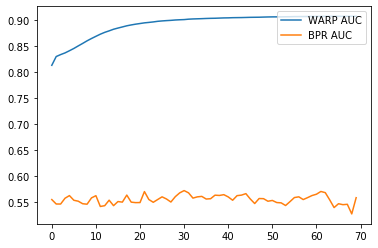

In [136]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

In [ ]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.legend(['WARP duration', 'BPR duration'], loc='upper right')
plt.show()

In [ ]:
warp_model = LightFM(no_components=num_components,
                     max_sampled=3,
                    loss='warp',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
warp_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test).mean())

x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.legend(['WARP duration'], loc='upper right')
plt.title('Duration')
plt.show()

x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.legend(['WARP AUC'], loc='upper right')
plt.title('AUC')
plt.show()

### Let's also try building a fanworks (item) feature matrix.

In [ ]:
item_features = dataset.build_item_features(((x['work_id'], [x['category']])
                                              for x in get_fanworks_features()))
print(repr(item_features))

# Let's try to get recommendations out

In [ ]:
def sample_recommendation(model, data, user_ids):


    n_users, n_items = data.shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]

        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['work_id'][np.argsort(-scores)]

        print("User %s" % user_id)
        print("     Known positives:")

        #for x in known_positives[:3]:
        #    print("        %s" % x)

        print("     Recommended:")

        for x in top_items[:3]:
            print("        %s" % x)

In [ ]:
sample_recommendation(model, kudos, [3, 25, 450])

In [153]:
def sample_fanworks_rec(model, dataset, users):

    n_users, n_items = dataset.interactions_shape()
    
    for user_name in users:
        #known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        user_id = dataset.mapping()[0][user_name]
        
        scores2 = model.predict(user_id, np.arange(n_items))
        #top_items = data['work_id'][np.argsort(-scores)]
        top_indices = np.argsort(-scores2)
        #top_items = dataset.mapping()[2][np.argsort(-scores)]

        print(f"User {user_id} {user_name}")
        print("     Known positives:")
        

        #for x in known_positives[:3]:
        #    print("        %s" % x)

        print("     Recommended:")

        for x in top_indices[:10]:

            y = dict(map(reversed, dataset.mapping()[2].items()))[x]
            print(f"http://www.archiveofourown.org/works/{y}")

In [154]:
sample_fanworks_rec(model, dataset, ['MapToWhereIAlreadyAm'])

User 2971 MapToWhereIAlreadyAm
     Known positives:
     Recommended:
http://www.archiveofourown.org/works/2606978
http://www.archiveofourown.org/works/3967084
http://www.archiveofourown.org/works/3490910
http://www.archiveofourown.org/works/2599214
http://www.archiveofourown.org/works/4332726
http://www.archiveofourown.org/works/5249699
http://www.archiveofourown.org/works/7030051
http://www.archiveofourown.org/works/2826071
http://www.archiveofourown.org/works/6070624
http://www.archiveofourown.org/works/4417469


In [63]:
print(dataset.interactions_shape())
print(dataset.mapping()[0]['MapToWhereIAlreadyAm'])

(18096, 4224)
2971


In [65]:
reversed_lookup_users = dict(map(reversed, dataset.mapping()[0].items()))
reversed_lookup_users = 

'MapToWhereIAlreadyAm'

In [81]:
print(dataset.mapping()[2])

{'3104510': 0, '6423526': 1, '9552773': 2, '5162474': 3, '4417469': 4, '6800461': 5, '5276975': 6, '5691409': 7, '5600314': 8, '7949938': 9, '4307715': 10, '7731400': 11, '9470711': 12, '13172817': 13, '8892910': 14, '8625148': 15, '5684185': 16, '16067255': 17, '18221840': 18, '14960156': 19, '12075666': 20, '13966560': 21, '11600223': 22, '9303272': 23, '5068015': 24, '12897576': 25, '13949562': 26, '5025610': 27, '11699232': 28, '3541511': 29, '5808097': 30, '8032450': 31, '7353133': 32, '6427147': 33, '13995180': 34, '7544575': 35, '6334627': 36, '8015536': 37, '4527786': 38, '10062053': 39, '7196108': 40, '10746336': 41, '3406271': 42, '13285578': 43, '3967084': 44, '10838289': 45, '11465352': 46, '3064295': 47, '5278049': 48, '10728954': 49, '12288612': 50, '8376922': 51, '7277554': 52, '12837480': 53, '7144571': 54, '10628475': 55, '13597905': 56, '8135873': 57, '7799950': 58, '2606978': 59, '17435678': 60, '6357565': 61, '10610031': 62, '13598769': 63, '10470963': 64, '3363869'

In [87]:
scores = model.predict(2971, np.arange(4224))
sorted_scores = np.argsort(-scores)
sorted_scores

array([  59,   44,  190, ..., 3399, 1644,  342])

In [ ]:
#top_items = data['work_id'][np.argsort(-scores)]
top_items = dataset.mapping()[2][np.argsort(-scores)]